# 이미지/기초과제/손글씨 탐지

이 노트북은 셀을 차례로 실행하여 이미지 과제의 전반적인 과정을 수행해볼 수 있게 제작되었습니다.

## 과제 설명
손글씨로 쓰여진 텍스트 이미지에서 텍스트를 탐지하는 과제

## 데이터 설명
- 학습 데이터 : 손글씨 이미지 데이터(.png)

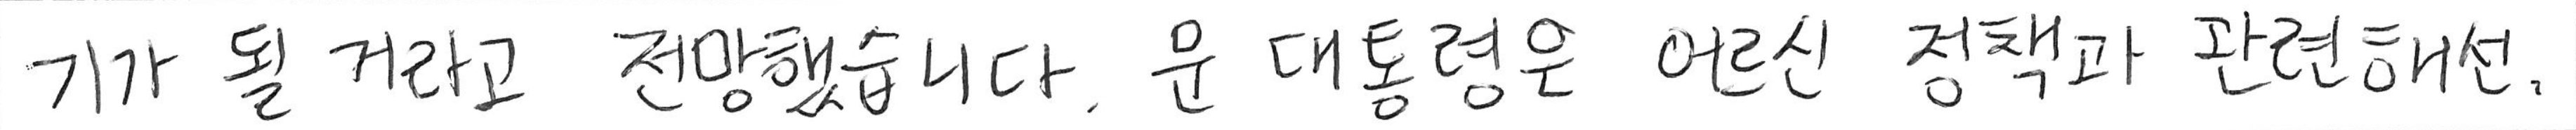

- 라벨 데이터 : 이미지의 크기, 파일명, 텍스트 등의 정보가 딕셔너리 형태로 담긴 데이터(.json)

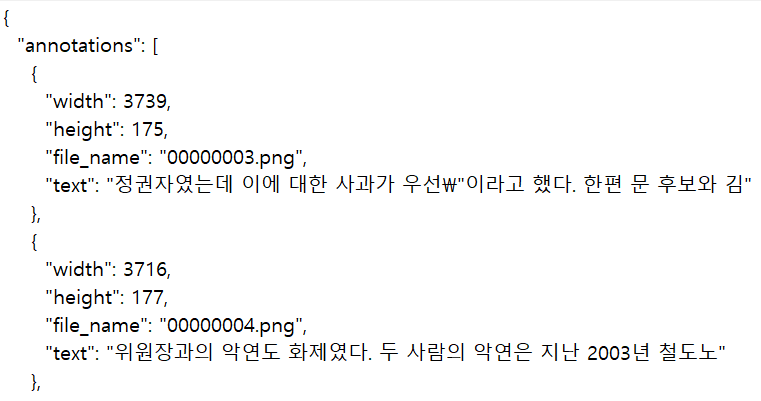

- 데이터셋 구성
  - train: 5772개의 png 파일과 1개의 json 파일
  - test: 1077개의 png 파일과 1개의 json 파일

## 자주 사용되는 RNN 모델
- LSTM, GRU 등

## 코드 구조
이 베이스라인 코드는 간단하게 아래 네 단계로 이루어져 있습니다.
- `1.데이터`: 사용할 데이터셋을 가져오고 모델에 전달할 Dataloader 생성
  - `class CustomDataset`: 데이터를 불러오고 (필요할 경우) 데이터 전처리 진행, 및 torch.utils.data.DataLoader의 첫번째 인자 형식으로 변환
  - `torch.utils.data.DataLoader(dataset, batch_size=, ...)`: 모델에 공급할 데이터 로더 생성
- `2.모델 설계`: 학습 및 추론에 사용할 모델 구조 설계
  - `class CRNN`: 모델 구조 설계
- `3.학습`: 설계된 모델로 데이터 학습
  - 학습된 모델은 `.ipynb` 코드와 같은 경로에 저장됨
- `4.추론`: 학습된 모델을 사용해 테스트 데이터로 추론
  - 학습된 모델로 테스트 데이터에 대한 추론을 진행
  - 추론 결과는 `.ipynb` 코드와 같은 경로에 저장됨. 이를 플랫폼에 업로드해 점수 확인

## 세팅
### 라이브러리
- 코드 전반에 사용되는 라이브러리를 설치 및 로드합니다.

In [101]:
# 설치되지 않은 라이브러리의 경우, 주석 해제 후 코드를 실행하여 설치
# !pip install torch
# !pip install 

In [102]:
# 필요한 라이브러리 불러오기
import os
import json
import random
import numpy as np
import pandas as pd
import argparse
import collections
from PIL import Image
from glob import glob
import sklearn
import sklearn.metrics

import torch
import torch.nn as nn
from torch.nn import CTCLoss
from torch.utils import data
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms

from utils.unicode import split_syllables, join_jamos

In [103]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
os.environ["CUDA_VISIBLE_DEVICES"]="3"
print(device)

# 경로 설정
DATASET_PATH = './data/'

cuda


## 데이터
### 전처리 방법

해당 베이스라인에서는 이미지 과제에서 자주 사용되는 resize, normalize, bilinear interpolation 등을 적용합니다.
- resize : 손글씨 각 이미지 파일의 크기가 다른 점을 보정하기 위해 지정된 규격으로 이미지 크기를 통일합니다.
- normalize : 정규분포를 따르는 변수에서 평균을 빼고 표준편차로 나누면 표준정규분포를 따르게 되듯이, 마찬가지로 일정 값을 빼고 또한 나눠 정규화를 해줍니다.
- bilinear interpolation : bilinear interpolation 방법은 이미지와 같은 height, width의 속성을 가지는 데이터에 적합한 interpolation 방법입니다.
  -  height, width로 구성된 2차원 평면이므로 interpolation 할 때 사용되는 변수도 2개입니다.
  - 이 방법은 단 방향의, 1개의 변수를 이용하여 interpolation 하는 linear 보다 좀 더 나은 방법입니다.

### 데이터 로드 및 전처리
- 데이터 로드 및 이미지 데이터 사이즈 변경, 표준화 등을 위한 클래스 정의

In [104]:
class CustomDataset(data.Dataset):
    """ 필수 함수 : 
        - __init__ : 초기화
        - __len__ : 데이터셋(input)의 길이 반환
        - __getitem__ : 데이터셋을 인덱스로 불러옴
        
        그 외 함수:
        - get_root : 경로 반환
        - get_img_path : 인덱스 출력
    """
 
    def __init__(self, root, phase='train', transform=None, target_transform=None):
        # 경로 생성 후 생성된 경로의 이미지 파일을 불러와 정렬한 다음 저장
        self.root = os.path.join(root, phase)
        self.labels = []
        self.transform = transform
        self.target_transform = target_transform
        annotations = None

        if phase == 'val':
            self.root = os.path.join(root, 'train')
        # 라벨 데이터인 json 파일을 불러와 저장한 다음 json 파일 안의 딕셔너리를 파일 이름 순으로 정렬
        with open(os.path.join(self.root, 'labels.json'), 'r', encoding="UTF-8") as label_json :
            label_json = json.load(label_json)
            annotations = label_json['annotations']
        annotations = sorted(annotations, key=lambda x: x['file_name'])
        
        self.imgs = sorted(glob(self.root + '/images' + '/*.png'))
        
        
        if phase == 'train':
            annotations = annotations[:int(0.9*len(annotations))]
            self.imgs = self.imgs[:int(0.9*len(self.imgs))]
        elif phase == 'val':
            annotations = annotations[int(0.9*len(annotations)):]
            self.imgs = self.imgs[int(0.9*len(self.imgs)):]

            
        for anno in annotations :
            if phase == 'test' :
                self.labels.append('dummy')
            else :
                self.labels.append(anno['text'])
        
        

    # training set의 손글씨 이미지들의 갯수 출력
    def __len__(self):
        return len(self.imgs)

    # 데이터 셋의 idx 번째 샘플 데이터를 반환
    def __getitem__(self, index):
        assert index <= len(self), 'index range error'
        img_path = self.imgs[index]
        # 이미지 모드 변경. 흰 배경에 검은 글씨 뿐이므로 그레이 스케일('L') 지정
        img = Image.open(img_path).convert('L')
        
        label = self.labels[index]

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return (img, label)
    
    # CustomDataset 클래스의 __init__ 메서드에서 정의한 self.root 출력
    def get_root(self) :
        return self.root

    # 해당 index의 이미지 파일의 경로 출력
    def get_img_path(self, index) :
        return self.imgs[index]
    

# 이미지 사이즈 변경(resize), 이중선형보간(bilinear interpolation), 텐서 변환, 표준화(normalize) 
class resizeNormalize(object):

    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation
        self.toTensor = transforms.ToTensor()

    def __call__(self, img):
        img = img.resize(self.size, self.interpolation)
        img = self.toTensor(img)
        img.sub_(0.5).div_(0.5)
        return img

    
class alignCollate(object): 

    def __init__(self, imgH=32, imgW=100):
        self.imgH = imgH
        self.imgW = imgW

    def __call__(self, batch):
        images, labels = zip(*batch)
       
        imgH = self.imgH
        imgW = self.imgW

        transform = resizeNormalize((imgW, imgH))
        images = [transform(image) for image in images]
        images = torch.cat([t.unsqueeze(0) for t in images], 0)

        return images, labels


class strLabelConverter(object):
  
    def __init__(self, alphabet, ignore_case=True):
        self._ignore_case = ignore_case        
        if self._ignore_case:
            alphabet = alphabet.lower()
        self.alphabet = alphabet + '-'  # for `-1` index
        
        self.dict = {}
        
        # 식별의 대상이 되는 특수문자, 숫자, 알파벳 대소문자, 한글 각 기호/글자에 넘버링
        for i, char in enumerate(alphabet):
            # NOTE: 0 is reserved for 'blank' required by wrap_ctc
            self.dict[char] = i + 1 
            
    def encode(self, text):
        """Support batch or single str.

        Args:
            text (str or list of str): texts to convert.

        Returns:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.
        """
        if isinstance(text, str): 
            text = split_syllables(text)
            # 필요 시 영어 문자를 모두 소문자 형식으로 반환
            text = [
                self.dict[char.lower() if self._ignore_case and char.isalpha() else char]
                for char in text
            ]
            length = [len(text)]
            
        elif isinstance(text, collections.abc.Iterable):
            length = [len(split_syllables(s)) for s in text]
            text = ''.join(text)
            text, _ = self.encode(text)
        
        return (torch.IntTensor(text), torch.IntTensor(length))

    def decode(self, t, length, raw=False):
        """Decode encoded texts back into strs.

        Args:
            torch.IntTensor [length_0 + length_1 + ... length_{n - 1}]: encoded texts.
            torch.IntTensor [n]: length of each text.

        Raises:
            AssertionError: when the texts and its length does not match.

        Returns:
            text (str or list of str): texts to convert.
        """
        if length.numel() == 1:
        # torch.numel(input) -> int : returns the total number of elements in the input tensor.
            length = length[0]
            assert t.numel() == length, "text with length: {} does not match declared length: {}".format(t.numel(), length)
            if raw:
                return join_jamos(''.join([self.alphabet[i - 1] for i in t]))
            else:
                char_list = []
                for i in range(length):
                    if t[i] != 0 and (not (i > 0 and t[i - 1] == t[i])):
                        char_list.append(self.alphabet[t[i] - 1])
                return join_jamos(''.join(char_list))
        else:
            # batch mode
            assert t.numel() == length.sum(), "texts with length: {} does not match declared length: {}".format(t.numel(), length.sum())
            texts = []
            index = 0
            for i in range(length.numel()):
                l = length[i]
                texts.append(
                    self.decode(
                        t[index:index + l], torch.IntTensor([l]), raw=raw))
                index += l
            return texts
  
        
def loadData(v, data):
    d_size = data.size()
    v.resize_(d_size).copy_(data)

In [105]:
# DATASET 만들기
train_dataset = CustomDataset(DATASET_PATH, phase='train')
validation_dataset = CustomDataset(DATASET_PATH, phase='val')

# 데이터 로드 파라미터
batch = 5
imgH = 32
imgW = 1600

# DATASET 로딩하기
train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True, collate_fn=alignCollate(imgH=imgH, imgW=imgW))
val_loader = DataLoader(validation_dataset, batch_size=batch, shuffle=False, collate_fn=alignCollate(imgH=imgH, imgW=imgW))

## 모델 설계
- 파이토치로 신경망을 구축할 때 사용되는 함수들은 torch.nn 패키지에 속해 있다.
- torch.nn.Module 클래스의 상속 클래스를 생성하여 모델을 원하는 방식으로 구체적으로 설계한다.

In [106]:
# torch.nn.Module 클래스 상속 후 모델에 필요한 연산 정의 및 모델 내 연산 순서 설정
class BidirectionalLSTM(nn.Module): # torch.nn.Module 클래스 상속

    def __init__(self, nIn, nHidden, nOut):
        super(BidirectionalLSTM, self).__init__()
        self.rnn = nn.LSTM(nIn, nHidden, bidirectional=True)
        self.embedding = nn.Linear(nHidden * 2, nOut)

    def forward(self, input):
        recurrent, _ = self.rnn(input)
        T, b, h = recurrent.size()
        t_rec = recurrent.view(T * b, h)

        output = self.embedding(t_rec)  # [T * b, nOut]
        output = output.view(T, b, -1)

        return output


class CRNN(nn.Module): # torch.nn.Module 클래스 상속

    def __init__(self, imgH, nc, nclass, nh, n_rnn=2, leakyRelu=False):
        super(CRNN, self).__init__()
        assert imgH % 16 == 0, 'imgH has to be a multiple of 16'
        
        ks = [3, 3, 3, 3, 3, 3, 2]
        ps = [1, 1, 1, 1, 1, 1, 0]
        ss = [1, 1, 1, 1, 1, 1, 1]
        nm = [64, 128, 256, 256, 512, 512, 512]

        cnn = nn.Sequential()

        def convRelu(i, batchNormalization=False):
            nIn = nc if i == 0 else nm[i - 1]
            nOut = nm[i]
            cnn.add_module('conv{0}'.format(i),
                           nn.Conv2d(nIn, nOut, ks[i], ss[i], ps[i]))
            if batchNormalization:
                cnn.add_module('batchnorm{0}'.format(i), nn.BatchNorm2d(nOut))
            if leakyRelu:
                cnn.add_module('relu{0}'.format(i),
                               nn.LeakyReLU(0.2, inplace=True))
            else:
                cnn.add_module('relu{0}'.format(i), nn.ReLU(True))
       
        convRelu(0)
        cnn.add_module('pooling{0}'.format(0), nn.MaxPool2d(2, 2))
        convRelu(1)
        cnn.add_module('pooling{0}'.format(1), nn.MaxPool2d(2, 2))
        convRelu(2, True)
        convRelu(3)
        cnn.add_module('pooling{0}'.format(2),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1))) 
        convRelu(4, True)
        convRelu(5)
        cnn.add_module('pooling{0}'.format(3),
                       nn.MaxPool2d((2, 2), (2, 1), (0, 1)))
        convRelu(6, True)

        self.cnn = cnn
        self.rnn = nn.Sequential(
            BidirectionalLSTM(512, nh, nh),
            BidirectionalLSTM(nh, nh, nclass))

    def forward(self, input):
        # conv features
        conv = self.cnn(input)
        b, c, h, w = conv.size()
        assert h == 1, "the height of conv must be 1"
        conv = conv.squeeze(2)
        conv = conv.permute(2, 0, 1)  # [w, b, c]
        # rnn features
        output = self.rnn(conv)

        return output

## 학습
### 사용할 파라미터
- `optimizer` : 손실함수 값이 최소가 되는 부분을 찾기 위해 학습율과 기울기를 다양하게 수정하여 가중치를 변경시키는 것을 최적화라고 하고, 최적화의 다양한 방식들을 옵티마이저라고 합니다.
- `epoch` : 한 번의 epoch는 인공 신경망에서 전체 데이터 셋에 대해 forward pass/backward pass 과정을 거친 것입니다.
  - 즉, epoch이 1만큼 지나면, 전체 데이터 셋에 대해 한번의 학습이 완료된 상태입니다.
  - 모델을 만들 때 적절한 epoch 값을 설정해야만 underfitting과 overfitting을 방지할 수 있습니다.
  - 1 epoch = (데이터 갯수 / batch size) interations


In [107]:
model_dir = 'save/' 

def save_model(model_name, model, optimizer, scheduler):
    os.makedirs(os.path.join(model_dir),exist_ok=True)
    state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict()
    }
    torch.save(state, os.path.join(model_dir, model_name + '.pth'))
    print(os.path.join(model_dir, model_name + '.pth'))
    print('model saved')    

    
def load_model(model_name, model, optimizer=None, scheduler=None):
    state = torch.load(os.path.join(model_dir, model_name + '.pth'))
    model.load_state_dict(state['model'])
    if optimizer is not None:
        optimizer.load_state_dict(state['optimizer'])
    if scheduler is not None:
        scheduler.load_state_dict(state['scheduler'])
    print('model loaded')        

In [ ]:
with open(os.path.join('data/train/labels' + '.json'), 'r', encoding="UTF-8") as label_json :
    handwritten_json = json.load(label_json)
    
sorted(handwritten_json['annotations'], key=lambda x: x['file_name'])[0]['text']
handwritten_json['annotations'][:5]

In [109]:
# evaluation을 위해 필요한 함수 정의

def editDistance(r, h):

    d = np.zeros((len(r)+1)*(len(h)+1), dtype=np.uint8).reshape((len(r)+1, len(h)+1))
    for i in range(len(r)+1):
        d[i][0] = i
    for j in range(len(h)+1):
        d[0][j] = j
    for i in range(1, len(r)+1):
        for j in range(1, len(h)+1):
            if r[i-1] == h[j-1]:
                d[i][j] = d[i-1][j-1]
            else:
                substitute = d[i-1][j-1] + 1
                insert = d[i][j-1] + 1
                delete = d[i-1][j] + 1
                d[i][j] = min(substitute, insert, delete)
    return d

# wer(wor error rate) 참조 링크
# https://docs.microsoft.com/ko-kr/azure/cognitive-services/speech-service/how-to-custom-speech-evaluate-data
def wer(r, h):

    # build the matrix
    d = editDistance(r, h)

    # print the result in aligned way
    result = float(d[len(r)][len(h)]) / len(r) * 100
    return result

def evaluation_metrics(pred_list):
    return evaluate(pred_list)


def evaluate(pred_list):
    

    total_wer = 0
    
    for i in range(len(pred_list)) :
        wer_val = wer(validation_dataset.labels[i].split(), pred_list[i].split())
        total_wer += wer_val
    ret = total_wer / len(pred_list)
    return ret

In [110]:
def train(num_epochs, model, device, train_loader, val_loader, images, texts, lengths, converter, optimizer, lr_scheduler, prediction_dir, print_iter) :
    criterion = CTCLoss()
    criterion.to(device)
    images = images.to(device)
    model.to(device)
    for epoch in range(1, num_epochs+1) :
        print(epoch, 'epoch')
        count = 0
        model.train()
        for i, datas in enumerate(train_loader) :
            datas, targets = datas
            batch_size = datas.size(0)
            count += batch_size
            loadData(images, datas)
            t, l = converter.encode(targets)
            loadData(texts, t)
            loadData(lengths, l)
            
            # 모델 학습 진행
            preds = model(images)
            # print(targets)
            # print(t.shape, l)
            # print(datas.shape + '->' + preds.shape))
            preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
            # loss 계산->back-propagation
            cost = criterion(preds, texts, preds_size, lengths) / batch_size
            model.zero_grad()
            cost.backward()
            optimizer.step()
            if count % print_iter < train_loader.batch_size :
                print('epoch {} [{}/{}] - loss : {:>6f}'.format(epoch, count, len(train_loader.dataset), cost))
            # break
        # 검증
        validation(model, device, val_loader, images, texts, lengths, converter, prediction_dir)
       
        save_model('{}_w{}'.format(epoch, imgW), model, optimizer, lr_scheduler)
        
        lr_scheduler.step()

def validation(model, device, val_loader, images, texts, lengths, converter, prediction_dir):
    image_path_list, pred_list = test(model, device, val_loader, images, texts, lengths, converter, prediction_dir)
    print('validation test finish')

    # 추론 점수 계산
    res = evaluation_metrics(pred_list)

    print('validation : {:>6f}'.format(res))
    
    
def test(model, device, test_loader, images, texts, lengths, converter, prediction_dir) :
    model.to(device)
    images = images.to(device)
    model.eval()
    image_path_list = test_loader.dataset.imgs
    pred_list = []
    os.makedirs(os.path.join(prediction_dir), exist_ok=True)
    for i, datas in enumerate(test_loader) :
        datas, targets = datas
        batch_size = datas.size(0)
        loadData(images, datas)
        t, l = converter.encode(targets)
        loadData(texts, t)
        loadData(lengths, l)

        # 추론
        preds = model(images)
        
        preds_size = Variable(torch.IntTensor([preds.size(0)] * batch_size))
        
        _, preds = preds.max(2)
        preds = preds.transpose(1, 0).contiguous().view(-1)
        # 추론 결과 decode
        pred_string = converter.decode(preds.data, preds_size.data, raw=False)
        
        # 추론 결과 list로 저장
        if type(pred_string) is str:
            pred_list.append(pred_string)
        else:
            pred_list.extend(pred_string)
        
    return image_path_list, pred_list

In [111]:
# 파라미터 지정   
# letter = " ,.()\'\"?!01234567890abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ가각간갇갈갉갊감갑값갓갔강갖갗같갚갛개객갠갤갬갭갯갰갱갸갹갼걀걋걍걔걘걜거걱건걷걸걺검겁것겄겅겆겉겊겋게겐겔겜겝겟겠겡겨격겪견겯결겸겹겻겼경곁계곈곌곕곗고곡곤곧골곪곬곯곰곱곳공곶과곽관괄괆괌괍괏광괘괜괠괩괬괭괴괵괸괼굄굅굇굉교굔굘굡굣구국군굳굴굵굶굻굼굽굿궁궂궈궉권궐궜궝궤궷귀귁귄귈귐귑귓규균귤그극근귿글긁금급긋긍긔기긱긴긷길긺김깁깃깅깆깊까깍깎깐깔깖깜깝깟깠깡깥깨깩깬깰깸깹깻깼깽꺄꺅꺌꺼꺽꺾껀껄껌껍껏껐껑께껙껜껨껫껭껴껸껼꼇꼈꼍꼐꼬꼭꼰꼲꼴꼼꼽꼿꽁꽂꽃꽈꽉꽐꽜꽝꽤꽥꽹꾀꾄꾈꾐꾑꾕꾜꾸꾹꾼꿀꿇꿈꿉꿋꿍꿎꿔꿜꿨꿩꿰꿱꿴꿸뀀뀁뀄뀌뀐뀔뀜뀝뀨끄끅끈끊끌끎끓끔끕끗끙끝끼끽낀낄낌낍낏낑나낙낚난낟날낡낢남납낫났낭낮낯낱낳내낵낸낼냄냅냇냈냉냐냑냔냘냠냥너넉넋넌널넒넓넘넙넛넜넝넣네넥넨넬넴넵넷넸넹녀녁년녈념녑녔녕녘녜녠노녹논놀놂놈놉놋농높놓놔놘놜놨뇌뇐뇔뇜뇝뇟뇨뇩뇬뇰뇹뇻뇽누눅눈눋눌눔눕눗눙눠눴눼뉘뉜뉠뉨뉩뉴뉵뉼늄늅늉느늑는늘늙늚늠늡늣능늦늪늬늰늴니닉닌닐닒님닙닛닝닢다닥닦단닫달닭닮닯닳담답닷닸당닺닻닿대댁댄댈댐댑댓댔댕댜더덕덖던덛덜덞덟덤덥덧덩덫덮데덱덴델뎀뎁뎃뎄뎅뎌뎐뎔뎠뎡뎨뎬도독돈돋돌돎돐돔돕돗동돛돝돠돤돨돼됐되된될됨됩됫됴두둑둔둘둠둡둣둥둬뒀뒈뒝뒤뒨뒬뒵뒷뒹듀듄듈듐듕드득든듣들듦듬듭듯등듸디딕딘딛딜딤딥딧딨딩딪따딱딴딸땀땁땃땄땅땋때땍땐땔땜땝땟땠땡떠떡떤떨떪떫떰떱떳떴떵떻떼떽뗀뗄뗌뗍뗏뗐뗑뗘뗬또똑똔똘똥똬똴뙈뙤뙨뚜뚝뚠뚤뚫뚬뚱뛔뛰뛴뛸뜀뜁뜅뜨뜩뜬뜯뜰뜸뜹뜻띄띈띌띔띕띠띤띨띰띱띳띵라락란랄람랍랏랐랑랒랖랗래랙랜랠램랩랫랬랭랴략랸럇량러럭런럴럼럽럿렀렁렇레렉렌렐렘렙렛렝려력련렬렴렵렷렸령례롄롑롓로록론롤롬롭롯롱롸롼뢍뢨뢰뢴뢸룀룁룃룅료룐룔룝룟룡루룩룬룰룸룹룻룽뤄뤘뤠뤼뤽륀륄륌륏륑류륙륜률륨륩륫륭르륵른를름릅릇릉릊릍릎리릭린릴림립릿링마막만많맏말맑맒맘맙맛망맞맡맣매맥맨맬맴맵맷맸맹맺먀먁먈먕머먹먼멀멂멈멉멋멍멎멓메멕멘멜멤멥멧멨멩며멱면멸몃몄명몇몌모목몫몬몰몲몸몹못몽뫄뫈뫘뫙뫼묀묄묍묏묑묘묜묠묩묫무묵묶문묻물묽묾뭄뭅뭇뭉뭍뭏뭐뭔뭘뭡뭣뭬뮈뮌뮐뮤뮨뮬뮴뮷므믄믈믐믓미믹민믿밀밂밈밉밋밌밍및밑바박밖밗반받발밝밞밟밤밥밧방밭배백밴밸뱀뱁뱃뱄뱅뱉뱌뱍뱐뱝버벅번벋벌벎범법벗벙벚베벡벤벧벨벰벱벳벴벵벼벽변별볍볏볐병볕볘볜보복볶본볼봄봅봇봉봐봔봤봬뵀뵈뵉뵌뵐뵘뵙뵤뵨부북분붇불붉붊붐붑붓붕붙붚붜붤붰붸뷔뷕뷘뷜뷩뷰뷴뷸븀븃븅브븍븐블븜븝븟비빅빈빌빎빔빕빗빙빚빛빠빡빤빨빪빰빱빳빴빵빻빼빽뺀뺄뺌뺍뺏뺐뺑뺘뺙뺨뻐뻑뻔뻗뻘뻠뻣뻤뻥뻬뼁뼈뼉뼘뼙뼛뼜뼝뽀뽁뽄뽈뽐뽑뽕뾔뾰뿅뿌뿍뿐뿔뿜뿟뿡쀼쁑쁘쁜쁠쁨쁩삐삑삔삘삠삡삣삥사삭삯산삳살삵삶삼삽삿샀상샅새색샌샐샘샙샛샜생샤샥샨샬샴샵샷샹섀섄섈섐섕서석섞섟선섣설섦섧섬섭섯섰성섶세섹센셀셈셉셋셌셍셔셕션셜셤셥셧셨셩셰셴셸솅소속솎손솔솖솜솝솟송솥솨솩솬솰솽쇄쇈쇌쇔쇗쇘쇠쇤쇨쇰쇱쇳쇼쇽숀숄숌숍숏숑수숙순숟술숨숩숫숭숯숱숲숴쉈쉐쉑쉔쉘쉠쉥쉬쉭쉰쉴쉼쉽쉿슁슈슉슐슘슛슝스슥슨슬슭슴습슷승시식신싣실싫심십싯싱싶싸싹싻싼쌀쌈쌉쌌쌍쌓쌔쌕쌘쌜쌤쌥쌨쌩썅써썩썬썰썲썸썹썼썽쎄쎈쎌쏀쏘쏙쏜쏟쏠쏢쏨쏩쏭쏴쏵쏸쐈쐐쐤쐬쐰쐴쐼쐽쑈쑤쑥쑨쑬쑴쑵쑹쒀쒔쒜쒸쒼쓩쓰쓱쓴쓸쓺쓿씀씁씌씐씔씜씨씩씬씰씸씹씻씽아악안앉않알앍앎앓암압앗았앙앝앞애액앤앨앰앱앳앴앵야약얀얄얇얌얍얏양얕얗얘얜얠얩어억언얹얻얼얽얾엄업없엇었엉엊엌엎에엑엔엘엠엡엣엥여역엮연열엶엷염엽엾엿였영옅옆옇예옌옐옘옙옛옜오옥온올옭옮옰옳옴옵옷옹옻와왁완왈왐왑왓왔왕왜왝왠왬왯왱외왹왼욀욈욉욋욍요욕욘욜욤욥욧용우욱운울욹욺움웁웃웅워웍원월웜웝웠웡웨웩웬웰웸웹웽위윅윈윌윔윕윗윙유육윤율윰윱윳융윷으윽은을읊음읍읏응읒읓읔읕읖읗의읩읜읠읨읫이익인일읽읾잃임입잇있잉잊잎자작잔잖잗잘잚잠잡잣잤장잦재잭잰잴잼잽잿쟀쟁쟈쟉쟌쟎쟐쟘쟝쟤쟨쟬저적전절젊점접젓정젖제젝젠젤젬젭젯젱져젼졀졈졉졌졍졔조족존졸졺좀좁좃종좆좇좋좌좍좔좝좟좡좨좼좽죄죈죌죔죕죗죙죠죡죤죵주죽준줄줅줆줌줍줏중줘줬줴쥐쥑쥔쥘쥠쥡쥣쥬쥰쥴쥼즈즉즌즐즘즙즛증지직진짇질짊짐집짓징짖짙짚짜짝짠짢짤짧짬짭짯짰짱째짹짼쨀쨈쨉쨋쨌쨍쨔쨘쨩쩌쩍쩐쩔쩜쩝쩟쩠쩡쩨쩽쪄쪘쪼쪽쫀쫄쫌쫍쫏쫑쫓쫘쫙쫠쫬쫴쬈쬐쬔쬘쬠쬡쭁쭈쭉쭌쭐쭘쭙쭝쭤쭸쭹쮜쮸쯔쯤쯧쯩찌찍찐찔찜찝찡찢찧차착찬찮찰참찹찻찼창찾채책챈챌챔챕챗챘챙챠챤챦챨챰챵처척천철첨첩첫첬청체첵첸첼쳄쳅쳇쳉쳐쳔쳤쳬쳰촁초촉촌촐촘촙촛총촤촨촬촹최쵠쵤쵬쵭쵯쵱쵸춈추축춘출춤춥춧충춰췄췌췐취췬췰췸췹췻췽츄츈츌츔츙츠측츤츨츰츱츳층치칙친칟칠칡침칩칫칭카칵칸칼캄캅캇캉캐캑캔캘캠캡캣캤캥캬캭컁커컥컨컫컬컴컵컷컸컹케켁켄켈켐켑켓켕켜켠켤켬켭켯켰켱켸코콕콘콜콤콥콧콩콰콱콴콸쾀쾅쾌쾡쾨쾰쿄쿠쿡쿤쿨쿰쿱쿳쿵쿼퀀퀄퀑퀘퀭퀴퀵퀸퀼큄큅큇큉큐큔큘큠크큭큰클큼큽킁키킥킨킬킴킵킷킹타탁탄탈탉탐탑탓탔탕태택탠탤탬탭탯탰탱탸턍터턱턴털턺텀텁텃텄텅테텍텐텔템텝텟텡텨텬텼톄톈토톡톤톨톰톱톳통톺톼퇀퇘퇴퇸툇툉툐투툭툰툴툼툽툿퉁퉈퉜퉤튀튁튄튈튐튑튕튜튠튤튬튱트특튼튿틀틂틈틉틋틔틘틜틤틥티틱틴틸팀팁팃팅파팍팎판팔팖팜팝팟팠팡팥패팩팬팰팸팹팻팼팽퍄퍅퍼퍽펀펄펌펍펏펐펑페펙펜펠펨펩펫펭펴편펼폄폅폈평폐폘폡폣포폭폰폴폼폽폿퐁퐈퐝푀푄표푠푤푭푯푸푹푼푿풀풂품풉풋풍풔풩퓌퓐퓔퓜퓟퓨퓬퓰퓸퓻퓽프픈플픔픕픗피픽핀필핌핍핏핑하학한할핥함합핫항해핵핸핼햄햅햇했행햐향허헉헌헐헒험헙헛헝헤헥헨헬헴헵헷헹혀혁현혈혐협혓혔형혜혠혤혭호혹혼홀홅홈홉홋홍홑화확환활홧황홰홱홴횃횅회획횐횔횝횟횡효횬횰횹횻후훅훈훌훑훔훗훙훠훤훨훰훵훼훽휀휄휑휘휙휜휠휨휩휫휭휴휵휸휼흄흇흉흐흑흔흖흗흘흙흠흡흣흥흩희흰흴흼흽힁히힉힌힐힘힙힛힝"
compat_jamo = ''.join(chr(i) for i in range(12593, 12643+1))
letter = " ,.()\'\"?!01234567890abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ" + compat_jamo
lr = 0.0001
cuda = True
num_epochs = 10
model_name = "10"
mode = "train"
prediction_dir = '/prediction/'
print_iter = 500
nclass = len(letter) + 1
nc = 1
print(len(letter))

123


In [112]:
# custom weights initialization called on crnn
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# 모델 선언
new_model = CRNN(imgH, nc, nclass, 256)
new_model.apply(weights_init)

converter = strLabelConverter(letter, ignore_case=True)
    
images = torch.FloatTensor(batch, 1, imgH, imgW)
texts = torch.IntTensor(batch * 1000)
lengths = torch.IntTensor(batch)
    
images = Variable(images)
texts = Variable(texts)
lengths = Variable(lengths)

#check parameter of model
print("------------------------------------------------------------")
total_params = sum(p.numel() for p in new_model.parameters())
print("num of parameter : ",total_params)
trainable_params = sum(p.numel() for p in new_model.parameters() if p.requires_grad)
print("num of trainable_ parameter :",trainable_params)
print("------------------------------------------------------------")

------------------------------------------------------------
num of parameter :  8375932
num of trainable_ parameter : 8375932
------------------------------------------------------------


## 학습

In [113]:
# mode == 'train'
print('train start')
params = [p for p in new_model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=lr, betas=(0.5, 0.999))
lr_scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=40,gamma=0.1)
# 정의해둔 train 함수에 파라미터를 입력해 학습 진행
train(num_epochs, new_model, device, train_loader, val_loader, images, texts, lengths, converter, optimizer, lr_scheduler, prediction_dir, print_iter)

train start
1 epoch
epoch 1 [500/5194]loss : 0.6436401605606079
epoch 1 [1000/5194]loss : 0.6489673256874084
epoch 1 [1500/5194]loss : 0.6290965676307678
epoch 1 [2000/5194]loss : 0.6204094886779785
epoch 1 [2500/5194]loss : 0.618312418460846
epoch 1 [3000/5194]loss : 0.6131537556648254
epoch 1 [3500/5194]loss : 0.5761620402336121
epoch 1 [4000/5194]loss : 0.5587865114212036
epoch 1 [4500/5194]loss : 0.559559166431427
epoch 1 [5000/5194]loss : 0.516693115234375
validation test finish
validation :  100.0
save/1.pth
model saved
2 epoch
epoch 2 [500/5194]loss : 0.46832403540611267
epoch 2 [1000/5194]loss : 0.42988982796669006
epoch 2 [1500/5194]loss : 0.4010830819606781
epoch 2 [2000/5194]loss : 0.3867376744747162
epoch 2 [2500/5194]loss : 0.353426992893219
epoch 2 [3000/5194]loss : 0.3628588318824768
epoch 2 [3500/5194]loss : 0.32968971133232117
epoch 2 [4000/5194]loss : 0.23781628906726837
epoch 2 [4500/5194]loss : 0.28590092062950134
epoch 2 [5000/5194]loss : 0.2743186354637146
validat

## 추론

In [114]:
print('test start')
test_dataset = CustomDataset(DATASET_PATH, phase='train')
test_loader = DataLoader(test_dataset, batch_size=batch, shuffle=False, collate_fn=alignCollate(imgH=imgH, imgW=imgW))
load_model(model_name, new_model)
# 정의해둔 test 함수에 파라미터를 입력해 추론 진행
test_imgs, test_preds = test(new_model, device, test_loader, images, texts, lengths, converter, prediction_dir)

test start
model loaded


In [115]:
# 제출 결과 저장
submit = pd.DataFrame(columns = ['file_name','text'])
for i,img in enumerate(test_imgs):
    submit.loc[len(submit)] = [img.split('/')[-1], test_preds[i]]

In [116]:
submit.tail()

,file_name,text
5189,images\00105564.png,력으로 지복하고 이는 '다리아몬드 화일랜드'ㅇ 포함돼 있어 아 긑은
5190,images\00105566.png,법무부는 ㅌ일 프랑스의 물하 제착법헤로르 그룹의 로베르로르 회간
5191,images\00105567.png,이 서울의 공가된 강소네서 큽으중 건 대후ㅡ로ㅜ 확잘을 만났다는 돠
5192,images\00105568.png,"신보도와 관련, 가능성이 매투 희방하다""는 반옹을 보몄다. 길닥ㄹ"
5193,images\00105569.png,"버부보 공보관은 ""기무중이 몁의로 된 한극 여괸과 프란드 여퀀를 모"


In [117]:
# 제출 파일 제작
submit.to_csv(f'save/pred_220603_w{imgW}.csv', index=False)